<a href="https://colab.research.google.com/github/dtabuena/Images/blob/main/DFOF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tifffile
import numpy as np
from google import colab
from matplotlib import pyplot as plt
import scipy
from tqdm import tqdm
import matplotlib as mpl

# # Open Bin Save
def get_drobox_file(new_filename, link):
    !wget -O $new_filename $link
    return new_filename


def bin_stack(im,bin_factor):
    height = im.shape[1] // bin_factor
    width = im.shape[2] // bin_factor
    im = im[:, :height * bin_factor, : width * bin_factor]
    im = im.reshape(im.shape[0], height, bin_factor, width, bin_factor)
    im = im.sum((2, 4), dtype='uint32')
    return im


def open_bin_save(db_link,new_name,bin_factor):
    print('importing')
    _ = get_drobox_file(new_name, db_link)
    print('reading')
    im = tifffile.imread('/content/'+new_name, maxworkers=6)
    print('binning')
    im = bin_stack(im, bin_factor)
    print('saving')
    tifffile.imwrite('/content/my_tiff_bin.tiff', im) #, imagej=True

    # !zip -r '/content/my_tiff_bin.zip' '/content/my_tiff_bin.tiff'

    print('downloading')
    colab.files.download('/content/my_tiff_bin.tiff')
    return im



In [3]:
# bleach_trace = exp_func(np.arange(len(trace)), .2, 20000, .8)
# fig,ax=plt.subplots()
# ax.plot(trace_dff,'k')
# ax.plot(bleach_trace,'r')

In [4]:
from scipy.signal import butter,filtfilt

def df_trace(trace,ref_inds):
    f0 = np.mean(trace[ref_inds])
    return (trace-f0)/f0

def exp_func(xdata,a,b,c):
    return a*np.exp(xdata/-b) + c

def z_trace(trace):
    std = np.std(trace)
    mean = np.mean(trace)
    z_param =  {'std':std, 'mean':mean}
    return (trace-mean)/std, z_param

def bleach_cor(trace,ref_inds,lpf=0.2,order=1):
    b, a = butter(order, lpf, btype='lowpass')
    trace_f = filtfilt(b, a, trace)
    y_fittable = trace_f[ref_inds]
    p0= [np.max(trace), 20000, np.min(trace)]
    min_bound = [0,1000,0]
    max_bound = [np.max(trace)*2,np.inf,np.max(trace)*2]
    p = scipy.optimize.curve_fit(exp_func, ref_inds, y_fittable,p0=p0,bounds=(min_bound,max_bound))
    bleach_trace = exp_func(np.arange(len(trace)), p[0][0], p[0][1], p[0][2])
    trace_corr = trace/bleach_trace * bleach_trace[0]
    return trace_corr, bleach_trace


def proccess_pxl(trace,ref_inds,df_ind):
    trace = trace.astype('float32')    
    trace_corr, bleach_trace = bleach_cor(trace,ref_inds)
    trace_df = df_trace(trace_corr,df_inds)
    return trace_df





In [131]:
im_max = np.max(im,axis=0)
im_n = im/im_max
im_rep = np.mean(im_n,axis=1)

_, bleach_trace = bleach_cor(im_rep,ref_inds)
bleach_trace = np.expand_dims(bleach_trace,1)
im_a = im/bleach_trace * bleach_trace[0]


In [123]:
new_name = 'my_tiff.tiff'
db_link = 'https://www.dropbox.com/s/25s9avjszghte1k/s3_cnt%5B1-5000_EX0%5D.TIF?dl=0'
bin_factor=10

# _ = get_drobox_file(new_name, db_link)
im = tifffile.imread('/content/'+new_name, maxworkers=6)
if bin_factor>1: im = bin_stack(im, bin_factor)

og_shape = im.shape
im = np.reshape(im,[og_shape[0],og_shape[1]*og_shape[2]])
print(og_shape)

(5000, 60, 60)


In [132]:
# im =im.astype('float32')
# ref_inds= np.concatenate([np.arange(100,1000),np.arange(4980,4999)])
# df_inds = np.arange(900,1000)
# for pix in tqdm( range(im.shape[1]) ):
#     im[:,pix] = proccess_pxl(im[:,pix],ref_inds,df_inds)

tifffile.imwrite('/content/my_tiff_corr.tiff', np.reshape(im_a ,og_shape) ) #, imagej=True
print('downloading')
colab.files.download('/content/my_tiff_corr.tiff')

downloading


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
# plt.plot(yhat[:,px])
# plt.plot(xdata_trunk,ydata)
# plt.show()

In [ ]:
def exp_func_n(xdata,a,b,c):   
    a = np.expand_dims(a,1).T
    b = np.expand_dims(b,1).T
    c = np.expand_dims(c,1).T
    xdata = np.expand_dims(xdata,1)
    # print(a.shape,b.shape,c.shape,xdata.shape)
    y_hat = a*np.exp(xdata/-b) + c
    return y_hat

def exp_func_err(abc,xdata,ydata):
    # print(xdata.shape,ydata.shape,abc.shape)
    n = ydata.shape[1]
    yhat = exp_func_n(xdata,abc[0:n],abc[n:n*2],abc[n*2:n*3])
    # print(yhat.shape,ydata.shape)
    er = np.sum(np.square(ydata - yhat).flatten() )
    print('er',er)
    return er

xdata = np.arange(im.shape[0])
xdata_trunk = xdata[ref_inds]
ydata = im[xdata_trunk,:]

ydata_max = np.max(ydata,axis=0)

ydata = ydata/ydata_max
# print(ydata.shape)

min_bounds = [0,1000,0]
max_bounds = [2,100000,np.max(ydata)*2]

a = np.ones(ydata.shape[1])*max_bounds[0]/2
b = np.ones(ydata.shape[1])*min_bounds[1]*10
c = np.ones(ydata.shape[1])*min_bounds[2]/2
abc = np.concatenate([a,b,c])



fig,ax=plt.subplots(1,2)
pos0 = ax[0].imshow(ydata.T)
fig.colorbar(pos0, ax=ax[0])

y_hat = exp_func_n(xdata_trunk,a,b,c)
pos1 = ax[1].imshow(y_hat.T)
fig.colorbar(pos1, ax=ax[1])


res = scipy.optimize.minimize(exp_func_err, abc, args=(xdata_trunk,ydata),options={'maxiter':10,'disp':True})

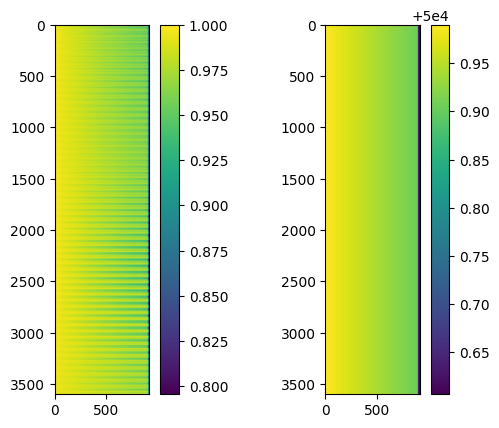

In [10]:
# def exp_func_err(xdata,ydata,a,b,c):
    # xdata = np.expand_dims(xdata,1)
    # return np.sum(np.abs(ydata - a*np.exp(xdata/-b) + c).flatten())

# im_test = im

# fit_range=np.arange(500,1100)
# xdata =  np.expand_dims(np.arange(im.shape[0]),1) * np.ones_like(im)
# xdata_trunk=xdata[fit_range,1]
# ydata = im_test[fit_range,:]
# p0_1 = [8,6000,-4]
# a=np.ones((1,im_test.shape[1]))*p0_1[0]
# b=np.ones((1,im_test.shape[1]))*p0_1[1]
# c=np.ones((1,im_test.shape[1]))*p0_1[2]



# def exp_func(xdata,a,b,c):   
#     a = np.expand_dims(a,1).T
#     b = np.expand_dims(b,1).T
#     c = np.expand_dims(c,1).T

#     # print(a.shape,b.shape,c.shape)
#     xdata = np.expand_dims(xdata,1)
#     return a*np.exp(xdata/-b) + c

# def exp_func_err(abc,xdata,ydata):    
#     n = ydata.shape[1]
#     # print(n)
#     yhat = exp_func(xdata,abc[0:n],abc[n:n*2],abc[n*2:n*3])
#     er = np.sum(np.square(ydata - yhat).flatten() )
#     print(er)
#     return er


# abc = np.stack((a,b,c),0)
# abc = abc.flatten()
# # yhat = exp_func(xdata_trunk,abc[0:n],abc[n:n*2],abc[n*2:n*3])

# res = scipy.optimize.minimize(exp_func_err, abc, args=(xdata_trunk,ydata),options={'maxiter':200,'disp':True})
# # n=50
# # 
# 
# 

In [11]:
# result = res['x']
# yhat = exp_func(xdata_trunk,result[0:n],result[n:n*2],result[n*2:n*3])
# plt.imshow(yhat.T)

In [12]:
# print(res)
# f= res['x']
# plt.plot(f)


In [13]:
# from matplotlib import pyplot as plt
# from sklearn.decomposition import FastICA, TruncatedSVD, SparsePCA
# # import sklearn

In [14]:
# from sklearn.decomposition import NMF
# n_components=12
# offset = 4
# model = NMF(n_components=n_components, init='random', random_state=0)
# W = model.fit_transform(im_r+offset)
# H = model.components_
# fig,ax=plt.subplots()
# ax.plot(W ) 

# h_r = np.reshape(H,[n_components,im_shape[1], im_shape[2]])
# fig,ax=plt.subplots(2,int(n_components/2),figsize=(15,3))
# ax = ax.flatten()
# for ki in range(n_components):
#     ax[ki].imshow(h_r[ki,:,:])

# fig,ax=plt.subplots(2,int(n_components/2),figsize=(15,3))
# ax = ax.flatten()
# for ki in range(n_components):
#     h_i = h_r[ki,:,:]
#     ax[ki].plot( np.sum(h_i,axis=0))
#     ax[ki].plot( np.sum(h_i,axis=1))# , np.arange(im_shape[1])

In [15]:
# backlist = [0,1,2]

# Background = W[:,backlist] @ H[backlist,:]
# im_corr = im_r - Background - offset
# # im_corr = (im_corr*im_r_std.T) + im_r_avg.T
# plt.imshow(im_corr.T)
# plt.colorbar()
# im_corr = np.reshape(im_corr,[im_shape[0],im_shape[1], im_shape[2]])

In [16]:
# tifffile.imwrite('/content/my_tiff_corr.tiff', im_corr) #, imagej=True
# print('downloading')
# colab.files.download('/content/my_tiff_corr.tiff')

In [17]:
# from sklearn.utils.extmath import randomized_svd
# n_components = 12
# u, s, vt = randomized_svd(im_r,n_components=n_components,n_iter=5,random_state=None)
# fig,ax=plt.subplots()
# ax.plot(u)
# ax.legend(np.arange(n_components))
# vt_r = np.reshape(vt,[n_components,im_shape[1], im_shape[2]])
# fig,ax=plt.subplots(2,int(n_components/2),figsize=(10,3))
# ax = ax.flatten()
# for ki in range(n_components):
#     ax[ki].imshow(vt_r[ki,:,:])


In [18]:

# ica = FastICA(n_components=n_components,random_state=0,whiten='unit-variance')
# im_trans =  ica.fit_transform(im_r_n.T)
# A_ = ica.mixing_  # Get estimated mixing matrix
# plt.plot(A_)
# plt.show()
# plt.plot(im_trans.T)
# plt.show()